In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import itertools
import warnings

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('C:/duh/Thinkful/Thinkful/Exercises/DEXUSEU.csv')

df['price'] = pd.to_numeric(df.DEXUSEU, errors='coerce')

df.dropna(inplace=True)

df.set_index(pd.to_datetime(df.DATE), inplace=True)

In [3]:
df.head(10)

,DATE,DEXUSEU,price
DATE,,,
2014-05-19,2014-05-19,1.3716,1.3716
2014-05-20,2014-05-20,1.3702,1.3702
2014-05-21,2014-05-21,1.3657,1.3657
2014-05-22,2014-05-22,1.3652,1.3652
2014-05-23,2014-05-23,1.3628,1.3628
2014-05-27,2014-05-27,1.3618,1.3618
2014-05-28,2014-05-28,1.3596,1.3596
2014-05-29,2014-05-29,1.3608,1.3608
2014-05-30,2014-05-30,1.3640,1.3640


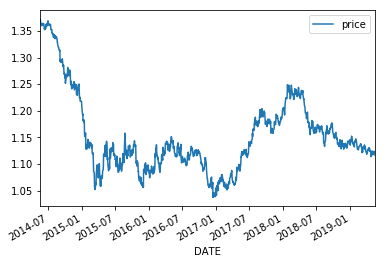

In [4]:
df.plot()
plt.show()

### Since the market was not open for 2 days of the week, we are missing data for every single day. So, we resample the data to be weekly, and take the mean.

In [5]:
df2 = df.resample('W').mean()

In [6]:
df2.head()

,price
DATE,
2014-05-25,1.36710
2014-06-01,1.36155
2014-06-08,1.36212
2014-06-15,1.35484
2014-06-22,1.35788


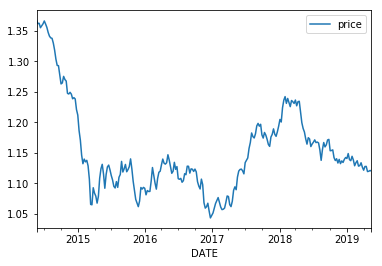

In [7]:
df2.plot()
plt.show()

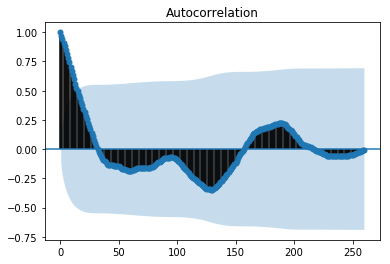

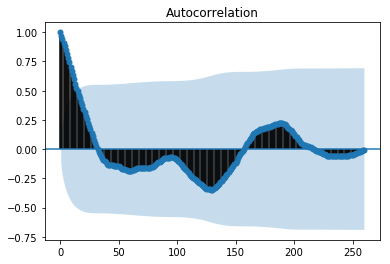

In [8]:
plot_acf(df2)

### You can notice that our data is not stationary, so we shall create stationarity in the data.


In [9]:
df2_diff = df2.diff(periods=1)

In [10]:
df2_diff.head()

,price
DATE,
2014-05-25,NaN
2014-06-01,-0.00555
2014-06-08,0.00057
2014-06-15,-0.00728
2014-06-22,0.00304


In [11]:
df2_diff = df2_diff[1:]
df2_diff.head()

,price
DATE,
2014-06-01,-0.00555
2014-06-08,0.00057
2014-06-15,-0.00728
2014-06-22,0.00304
2014-06-29,0.00332


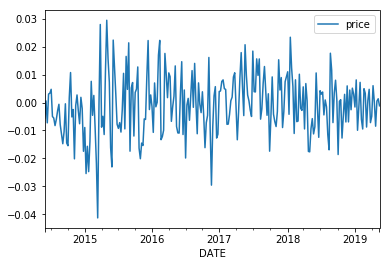

In [12]:
df2_diff.plot()
plt.show()

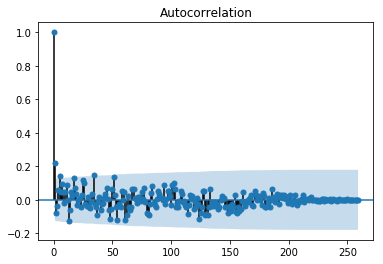

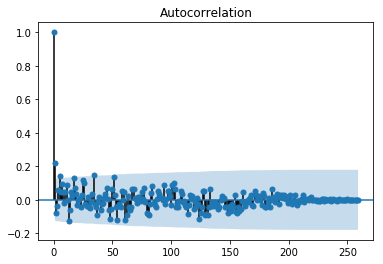

In [13]:
plot_acf(df2_diff)

### Let's check our PACF plots for our df2 and df2_diff dataframes.

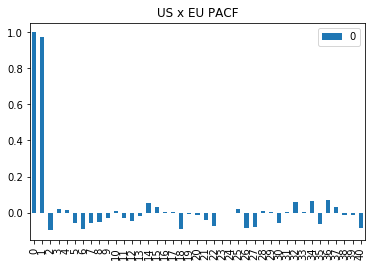

In [14]:
x_acf = pd.DataFrame(pacf(df2.price))
x_acf.plot(kind='bar')
plt.title('US x EU PACF')
plt.show()

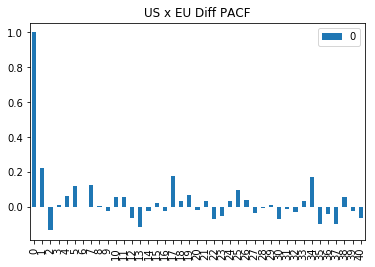

In [15]:
x_acf = pd.DataFrame(pacf(df2_diff.price))
x_acf.plot(kind='bar')
plt.title('US x EU Diff PACF')
plt.show()

### Now, let's create some ARIMA models. We're going to automate checking which values of P, D, and Q returns the lowest AIC value.

In [16]:
X = df2.values

train = df2[:210]
test = df2[210:]

In [17]:
p=d=q=range(0,10)
pdq = list(itertools.product(p,d,q))

In [18]:
thing = dict()
for param in pdq:
    try:
        model_arima = ARIMA(train, order=param)
        model_fit = model_arima.fit()
        thing[param] = model_fit.aic
        #print(param, model_fit.aic)
    except:
        continue

In [19]:
arima_df = pd.DataFrame.from_dict(thing, orient='index', columns=['AIC Score'])

In [20]:
arima_df.head()

,AIC Score
"(0, 0, 0)",-461.045155
"(0, 0, 1)",-720.678681
"(0, 1, 0)",-1282.505444
"(0, 1, 1)",-1296.606482
"(0, 1, 2)",-1294.617342


### Here, we discover that the P, D, Q parameters (with a maximum allowed variable of 10) that return the lowest AIC score are 5, 1, and 5, respectively.

In [21]:
arima_df.index[arima_df['AIC Score'] == arima_df['AIC Score'].min()]

Index([(5, 1, 5)], dtype='object')

In [22]:
model_arima = ARIMA(df2, order=(5, 1, 5))
model_fit = model_arima.fit()

preds = model_fit.forecast(steps=51)[0]

### Since the 5, 1, 5 model return the lowest AIC score, this is clearly the most logical model to use with our dataset.